In [ ]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

TensorFlow 2.x selected.


### Class Ensemble

In [ ]:
def _transition_matrix(n, eps):
    """Returns transition matrix without switchings.
    Args:
        n: int number, number of states in temperature space
        eps: float number, probability of incorrect step
    Returns:
        tf tensor of shape (2n, 2n), transition matrix
    """

    p_up = np.eye(n+1, dtype=np.float32)[:-1, 1:] * (1 - 2 * eps) +\
           eps * np.eye(n, dtype=np.float32) +\
           eps * np.eye(n+2, dtype=np.float32)[:-2, 2:]

    p_up[-1, -1] = 0
    p_up[-1, -2] = 1 - eps

    p_down = np.eye(n+1, dtype=np.float32)[1:, :-1]*(1 - 2 * eps) +\
             eps * np.eye(n, dtype=np.float32) +\
             eps * np.eye(n+2, dtype=np.float32)[2:, :-2]

    p_down[0, 0] = 0
    p_down[0, 1] = 1 - eps

    p0 = np.kron(np.array([[1., 0.], [0., 0.]], dtype=np.float32), p_down) +\
    np.kron(np.array([[0., 0.],[0., 1.]], dtype=np.float32), p_up)

    p0[n-1, 2*n-1] = 1
    p0[n, 0] = 1

    return tf.constant(p0)

@tf.function
def _switching_matrix(n, probs_up, probs_down):
    """Returns switching matrix
    Args:
        n: int number, number of states in temperature space
        probs_up: tf tensor of shape (m,), vector of prob. of switching from on
        to off m is number of states in uncomfortable zone
        probs_down: tf tensor of shape (m,), vector of prob. of switching from
        off to on m is number of states in uncomfortable zone
    Returns:
        tf tensor of shape (2n, 2n), switching matrix"""

    dim_out = probs_up.shape[0]

    p_up =  tf.concat([tf.zeros((1,)),
                       probs_up,
                       tf.zeros((n - dim_out,))], axis=0)

    p_down =  tf.concat([tf.zeros((n - dim_out,)),
                         probs_down,
                         tf.zeros((1,))], axis=0)

    p_rd = tf.eye(n) - tf.linalg.diag(p_down[1:])
    p_lu = tf.eye(n) - tf.linalg.diag(p_up[:-1])
    p_ru = tf.linalg.diag(p_down)[:-1, 1:]
    p_ld = tf.linalg.diag(p_up)[1:, :-1]

    p_s = tf.concat([tf.concat([p_lu, p_ld], axis=0), tf.concat([p_ru, p_rd], axis=0)], axis=1)
    return p_s

class Ensemble:

    def __init__(self, n, eps):
        """Returns object of class Ensamble
        Args:
            n: int number, number of states in temperature space
            eps: float number, probability of incorrect step
        Returns:
            object of class Ensamble"""

        self.p = _transition_matrix(n, eps)
        self.n = n

    def dynamics(self, in_state, T, f):
        """Returns dynamics of ensamble
        Args:
            in_state: tf.tensor of shape (2 * self.n), initial
            prob. distribution
            T: int number, number of time steps
            f: keras models which maps current consumption
            to probabilities of switching
        Returns:
            two tf tensors of shapes (T, 2 * self.n) and (T,) respectively,
            first tensor -- state of ens. vs time, second tensor -- U vs time"""

        state = in_state[:, tf.newaxis] # in state
        state_list = [] # will be filled by state vs time
        U_list = [] # will be filled by U vs time

        for i in range(T):

            state = self.p @ state # transition without switchings
            U = tf.reduce_sum(state[:self.n, 0]) # consumption
            probs_up, probs_down = f(tf.reshape(U, (1, 1))) # probabilities of switchings
            p_s = _switching_matrix(self.n, probs_up[0], probs_down[0]) # switching matr.
            state = p_s @ state # switchings
            state_list.append(state[:, 0])
            U_list.append(U)

        return tf.convert_to_tensor(state_list), tf.convert_to_tensor(U_list)


### Switching functions

In [ ]:
'''# the simplest switching function
def f(U):
    """Returns probabilities of switchings
    Args:
        U: tf tensor of shape (), consumption
    Returns:
        two tf tensors of shape (m,), first tensor -- probabilities
        of switching from on to off, second tensor -- probabilities
        of switching from off to on, m -- number of states in uncomfortable
        zone"""
    return [0.5 * tf.ones((10,)), 0.5 * tf.ones((10,))]'''

# simple keras model
inp = tf.keras.Input((1,))
h = tf.keras.layers.concatenate([inp, inp ** 2, inp ** 3, inp ** 4])
h = tf.keras.layers.Dense(24, activation=None)(h)
out = tf.keras.activations.sigmoid(h)
out1 = out[:, :12]
out2 = out[:, 12:]
simple_ann = tf.keras.Model(inputs=inp, outputs=[out1, out2])

simple_ann.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_pow (TensorFlowOpLa [(None, 1)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_pow_1 (TensorFlowOp [(None, 1)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_pow_2 (TensorFlowOp [(None, 1)]          0           input_1[0][0]                    
______________________________________________________________________________________________

### Penalty function

In [ ]:
def penalty(state_list,
            U,
            size_uncm_zone,
            alpha):
    """Returns penalty
    Args:
        state_list: tf tensor of shape (T, 2 * n), where T -- number
        of time steps, n -- number of states in ON(OFF) regime,
        mass function vs time
        U: tf tensor of shape (T,), consumption vs time
        size_uncm_zone: int number, size of uncomfortable zone
        alpha: float number from [0, 1], trade-off coeffitient
    Returns:
        tf tensor of shape (), value of penalty"""
    n = int(state_list.shape[1] / 2)

    comfort = tf.reduce_mean(tf.reduce_sum(state_list[:, :size_uncm_zone],
                                           axis=-1) +\
    tf.reduce_sum(state_list[:, n - size_uncm_zone:n + size_uncm_zone],
                  axis=-1) +\
    tf.reduce_sum(state_list[:, -size_uncm_zone:],
                  axis=-1))

    consumption = 2 * tf.reduce_mean(tf.math.abs(U - 0.5))

    return alpha * comfort + (1 - alpha) * consumption, comfort, consumption

### Optimization

100%|██████████| 300/300 [13:06<00:00,  2.62s/it]


Text(0, 0.5, '$p(x)$')

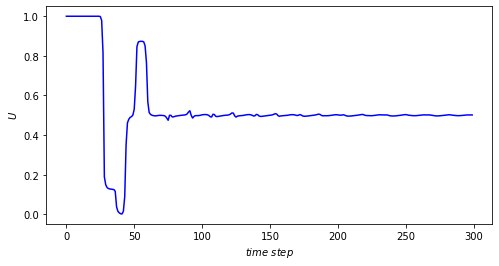

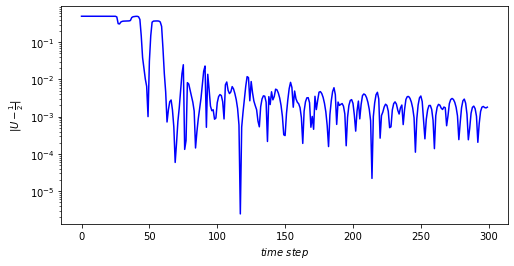

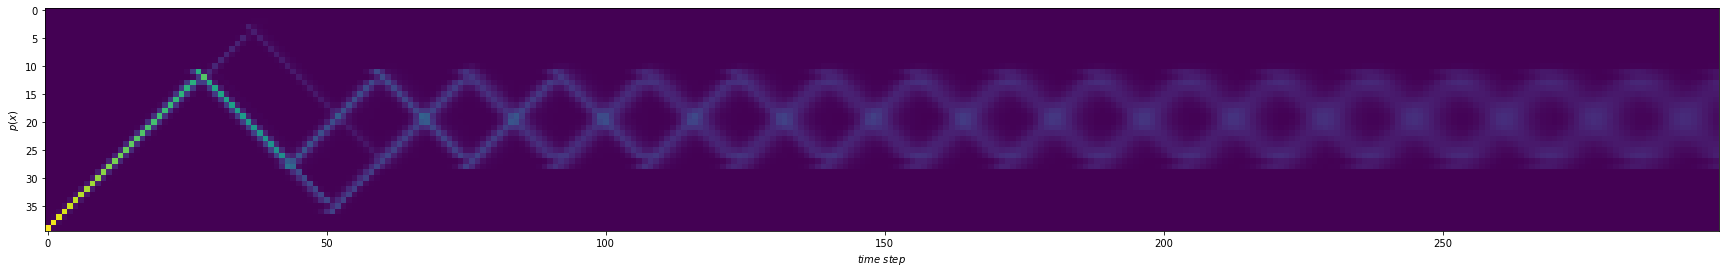

In [ ]:
#=====================Parameters of ensemble====================#
n = 40 # number of states in temperature space
eps = 0.01 # probability to make incorrect step (diffusion)
T = 300 # number of time steps
func = simple_ann # switching function
in_state = tf.constant((2 * n - 1) * [0] + [1],
                       dtype=tf.float32) # initial state
lr = 0.05 # learning rate
opt = tf.optimizers.Adam(lr, beta_1=0.9, beta_2=0.99) # optimizer
alpha = 0.55 # trade-off coefficient
iters = 300 # number of iterations
#===============================================================#

loss_list = []
comfort_list = []
consumption_list = []
for _ in tqdm(range(iters)):
    with tf.GradientTape() as tape:
        ens = Ensemble(n, eps) # ensemble initialization
        state_list, U_list = ens.dynamics(in_state, T, func) # simulation
        loss, comfort, consumption = penalty(state_list, U_list, 12, alpha)

    loss_list.append(loss)
    comfort_list.append(comfort)
    consumption_list.append(consumption)
    grad = tape.gradient(loss, func.weights)
    opt.apply_gradients(zip(grad, func.weights))

# plotting
plt.figure(figsize=(8, 4))
plt.plot(U_list, 'b')
plt.xlabel(r'$time \ step$')
plt.ylabel(r'$U$')

plt.figure(figsize=(8, 4))
plt.plot(tf.abs(U_list - 0.5), 'b')
plt.xlabel(r'$time \ step$')
plt.ylabel(r'$|U-\frac{1}{2}|$')
plt.yscale('log')

plt.figure(figsize=(30, 30))
plt.imshow(tf.transpose(state_list[:300, :ens.n] + state_list[:300, ens.n:]))
plt.xlabel(r'$time \ step$')
plt.ylabel(r'$p(x)$')

### Plotting loss vs iter and ANN output

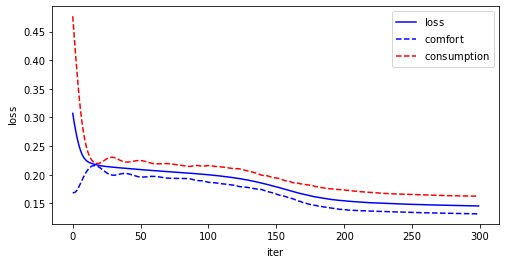

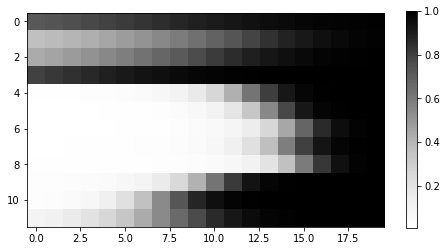

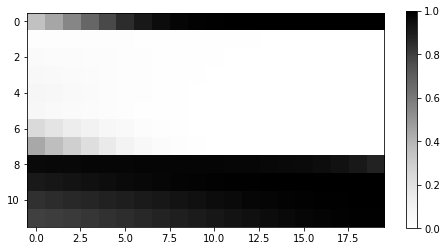

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_list, 'b')
plt.plot(comfort_list, 'b--')
plt.plot(consumption_list, 'r--')
plt.legend([r'${\rm loss}$', r'${\rm comfort}$', r'${\rm consumption}$'])
plt.xlabel(r'${\rm iter}$')
plt.ylabel(r'${\rm loss}}$')
plt.figure(figsize=(8, 4))
plt.imshow(tf.transpose(simple_ann(tf.range(0, 1, 0.05)[:, tf.newaxis])[0]),
           cmap='Greys')
plt.colorbar()
plt.figure(figsize=(8, 4))
plt.imshow(tf.transpose(simple_ann(tf.range(0, 1, 0.05)[:, tf.newaxis])[1]),
           cmap='Greys')
plt.colorbar()